##### exploring GANs on PyTorch

GANs are a class of unsupervised learning algorithms that are used to generate new data. They are composed of two networks: a generator and a discriminator. The generator is responsible for generating new data, and the discriminator is responsible for classifying the data as real or fake. The generator is trained to fool the discriminator, and the discriminator is trained to correctly classify the data. The generator and discriminator are trained in an adversarial manner, hence the name GANs.

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm

In [39]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
device

device(type='mps')

In [47]:
# import images from the dataset '../../../pytorch_learning/data/POKEMON' 
# and resize them to 64x64
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load the dataset, dont transform
dataset = torchvision.datasets.ImageFolder(root='../../../pytorch_learning/data/POKEMON', transform = transform)

# check the number of images in the dataset
print(len(dataset))
# check the number of classes in the dataset
print(len(dataset.classes))

801
1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
0


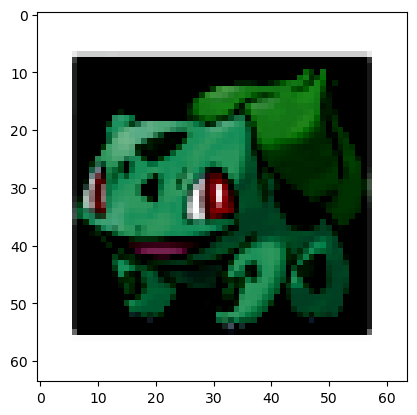

In [48]:
# load a single image from the dataset
img, label = dataset[0]
print(img.shape)
print(label)

# show the image
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [49]:
# create a dataloader to load the images in batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

# check the number of batches
print(len(dataloader))

201


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 64, 64]) torch.Size([4])


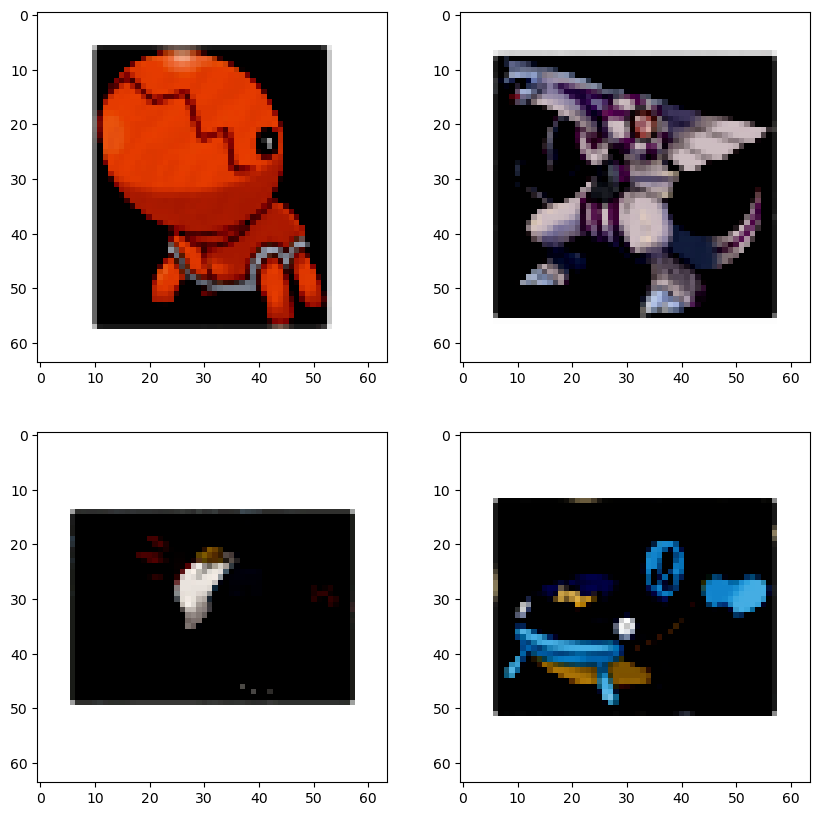

In [50]:
# taking a look at few images
examples = enumerate(dataloader)
batch_idx, (samples, labels) = next(examples)
print(samples.shape, labels.shape)

# show the images
fig = plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(samples[i].permute(1, 2, 0))
plt.show()

#### Simple GAN

The generator maps random noise through a model to produce a sample, and the discriminator decides whether the sample is real or not.

 There are two fundamental blocks in GANs.

Generator - The generator takes input as random noise and generates a data sample ideally in the latent space of the input dataset. Throughout the training, it tries to mimic the distribution of the input dataset.

Discriminator - The discriminator network is a binary classifier that outputs whether the sample is real or fake. The input to the discriminator could either come from an input dataset or generator, and its task is to classify whether the sample is real or fake.

In [51]:
# define the generator

class Generator(nn.Module):
    '''
    The Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    Methods:
        make_gen_block:
            Returns a sequence of linear layers. Final layer has tanh activation
        unsqueeze_noise:
            Reshapes the noise vector to pass into the generator
        forward:
            Takes the noise vector and returns a generated image
    '''


    def __init__(self, z_dim=100, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:  # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(), # we use tanh activation in the last layer to make the pixel values between -1 and 1
            )

    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1) # reshape the noise to pass it to the generator


    def forward(self, noise):
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 28, 28])


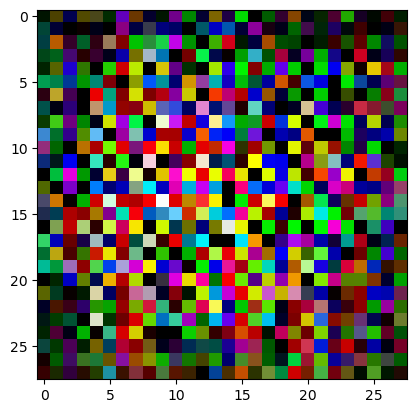

In [52]:
# lets pass an image to the generator and see what it returns
gen = Generator()
noise = torch.randn(1, 100)
fake_image = gen(noise)
print(fake_image.shape)

# show the image
plt.imshow(fake_image[0].detach().permute(1, 2, 0))

In [53]:
# define the discriminator

class Discriminator(nn.Module):
    '''
    The Discriminator Class
    Values:
        im_chan: the number of channels of the output image, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    Methods:
        make_disc_block:
            Returns a sequence of linear layers. Final layer has sigmoid activation
        forward:
            Takes an image tensor and returns a 1-dimension tensor
    '''

    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:  # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1) # flatten

In [54]:

# lets pass an image to the discriminator and see what it returns
disc = Discriminator()
pred = disc(fake_image)
print(pred)

tensor([[0.2197]], grad_fn=<ViewBackward0>)


In [62]:
dataset[0][0].shape

torch.Size([3, 64, 64])

In [65]:
# lets pass a real image to the discriminator and see what it returns
real_image = dataset[0][0].unsqueeze(0)
print(real_image.shape)
pred = disc(real_image)
print(pred)

torch.Size([1, 3, 64, 64])
tensor([[ 0.1772,  0.0949, -0.0901,  0.2576,  0.3637,  0.0113, -0.3579,  0.0437,
         -0.1920,  0.0292, -0.3997,  0.3837, -0.2554, -0.0111, -0.3513, -0.1251,
         -0.0302,  0.1627, -0.0284,  0.0993,  0.0418, -0.3834, -0.1601, -0.2920,
         -0.4442, -0.1741, -0.5813, -0.3005, -0.1568, -0.1141, -0.5475,  0.0335,
         -0.1232,  0.3145, -0.0340,  0.3295]], grad_fn=<ViewBackward0>)


In [55]:
# create a dataloader to load the images in batches
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

# check the number of batches
print(len(dataloader))

7


In [86]:

# define the hyperparameters
# these are the values used in the original paper
# you can change these and see how the results change

# the dimension of the noise vector
z_dim = 100
# size of the batches
batch_size = 128
# number of training epochs
n_epochs = 150
# learning rate for optimizers
lr = 0.0002
# beta values for Adam optimizers
beta_1 = 0.5
beta_2 = 0.999

# initialize the generator and the discriminator
gen = Generator(z_dim).to(device)
disc = Discriminator().to(device)

# training the model

# initialize the optimizers
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# initialize the BCE loss function
criterion = nn.BCEWithLogitsLoss()

# number of training batches
num_train_batches = len(dataloader)

# training loop
cur_step = 0
generator_losses = []
discriminator_losses = []
for epoch in range(n_epochs):
    # Dataloader returns the batches
    loop = tqdm.tqdm(dataloader)
    for real, _ in loop:
        cur_batch_size = len(real)

        # 1. Train the discriminator on real and fake images
        disc_opt.zero_grad()
        fake_noise = torch.randn(cur_batch_size, z_dim)
        fake = gen(fake_noise.to(device)) # feeding the noise to the generator to get the fake images
        disc_fake_pred = disc(fake.detach()) # feeding the fake images to the discriminator
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred)) # we want to classify the fake images as zeros

        disc_real_pred = disc(real.to(device)) # feeding the real images to the discriminator
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred)) # we want to classify the real images as ones
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() # update the discriminator

        # 2. Train the generator with an adversarial loss
        gen_opt.zero_grad()
        gen_fake_pred = disc(fake.to(device)) # feeding the fake images to the discriminator
        gen_loss = criterion(gen_fake_pred, torch.ones_like(gen_fake_pred)) # we want to classify the fake images as ones
        gen_loss.backward()
        gen_opt.step() # update the generator

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]
        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]
        # Output training stats
        if cur_step % 80 == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {gen_loss.item()}, discriminator loss: {disc_loss.item()}")
        cur_step += 1
        

 57%|█████▋    | 4/7 [00:01<00:00,  3.11it/s]

Step 80: Generator loss: 1.5484800338745117, discriminator loss: 0.6207566857337952


100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Step 160: Generator loss: 1.9079315662384033, discriminator loss: 0.477644681930542


 43%|████▎     | 3/7 [00:00<00:01,  3.08it/s]

Step 240: Generator loss: 1.8074760437011719, discriminator loss: 0.4576406478881836


100%|██████████| 7/7 [00:02<00:00,  3.45it/s]


Step 320: Generator loss: 2.169619083404541, discriminator loss: 0.4337505102157593


 29%|██▊       | 2/7 [00:00<00:01,  3.13it/s]

Step 400: Generator loss: 2.3723511695861816, discriminator loss: 0.334881454706192


 71%|███████▏  | 5/7 [00:01<00:00,  3.08it/s]

Step 480: Generator loss: 2.606956958770752, discriminator loss: 0.3264159858226776


 14%|█▍        | 1/7 [00:00<00:02,  2.96it/s]

Step 560: Generator loss: 2.8558614253997803, discriminator loss: 0.27113255858421326


 57%|█████▋    | 4/7 [00:01<00:00,  3.09it/s]

Step 640: Generator loss: 2.913393020629883, discriminator loss: 0.23420226573944092


100%|██████████| 7/7 [00:02<00:00,  3.47it/s]


Step 720: Generator loss: 2.972104787826538, discriminator loss: 0.27007848024368286


 43%|████▎     | 3/7 [00:00<00:01,  3.16it/s]

Step 800: Generator loss: 3.089522361755371, discriminator loss: 0.19974079728126526


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]


Step 880: Generator loss: 3.3229727745056152, discriminator loss: 0.1727113127708435


 29%|██▊       | 2/7 [00:00<00:01,  3.13it/s]

Step 960: Generator loss: 3.370790481567383, discriminator loss: 0.16195151209831238


 71%|███████▏  | 5/7 [00:01<00:00,  2.97it/s]

Step 1040: Generator loss: 3.5140459537506104, discriminator loss: 0.14344610273838043


100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


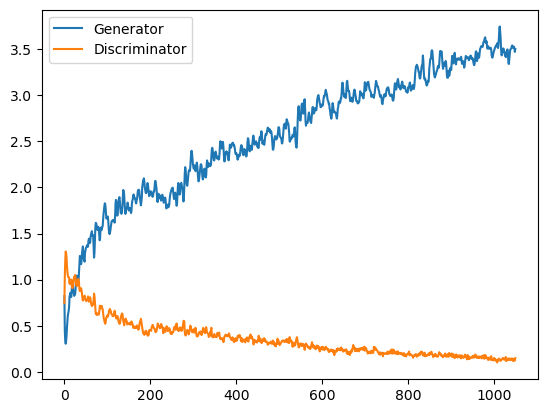

In [90]:
# plot the losses
plt.plot(generator_losses, label="Generator")
plt.plot(discriminator_losses, label="Discriminator")
plt.legend()

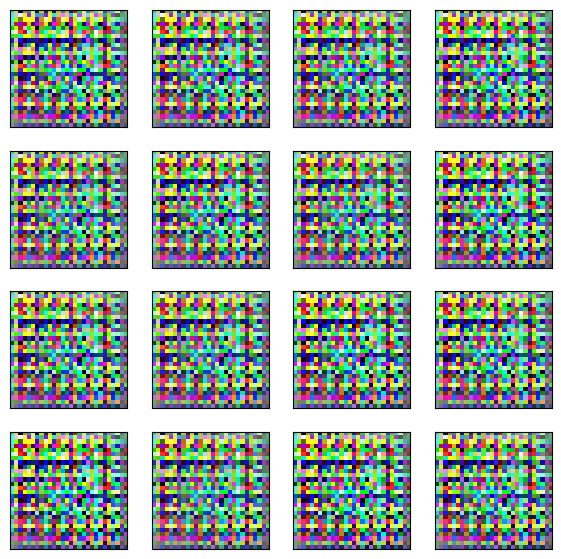

In [89]:
# lets see how the generator performs
# by viewing a batch of generated images
# after training
num_test_samples = 16
test_noise = torch.randn(num_test_samples, z_dim)
test_images = gen(test_noise.to(device))

# plot the images in the batch, along with the corresponding labels
fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
for ax, img in zip(axes.flatten(), test_images):
    img = img.detach().permute(1, 2, 0)
    img = img.cpu().numpy()
    img = (img + 1) / 2
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img)


> Presently the model is not good. There is definite scope for improvement. However, as a first attempt, it is an interesting exploration.